# Data Acquisition & Cleaning
Author: Stephen Kaplan, 7/30/2020

The purpose of this notebook is to output a single dataframe with which to build a linear regression model. This notebook fulfills that goal for 2 similar datasets that contain very similar features, but different targets. I ended up slightly pivoting what I was trying to predict while working on this project, which is justified at the end of `EDA & Modeling Workbook (Project V1).ipynb`. A brief description of the 2 questions I attempted to answer:

- **Project V1:**: Predicting [Pitchfork](https://pitchfork.com/) album ratings using Spotify's [Audio Features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) dataset. The Spotify dataset is provided for each track (song), so this involved attempting to aggregate the data into "album features". The Pitchfork data is acquired using a _web scraper_ and the audio features data come from the Spotify API.
- **Project V2:**: Predicting [Spotify](https://www.spotify.com) song "popularity" using Spotify's [Audio Features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) dataset. Both features and target are available via Spotify's API.

_Any reference to "V1" or "V2" corresponds to these 2 modeling attempts._

### Table of Contents

I. [Data Acquisition](#data-acquisition)
* [Scraping Pitchfork Album Ratings (V1 Target)](#scraping-pitchfork)
* [Track Audio Features from Spotify API (V1 & V2 Features)](#spotify-audio-features)
* [Track Popularity from Spotify API (V2 Target)](#spotify-popularity)
    
II. [Data Cleaning](#data-cleaning)
* [Cleaning Pitchfork Album Ratings Data](#clean-pitchfork)
* [Cleaning Spotify Track Audio Features Data](#cleaning-spotify-audio-features)
* [Cleaning Spotify Track Popularity Data](#cleaning-spotify-popularity)
    
III. [Final Dataset Preparation](#final-data-prep)
* [Dataset V1 (for predicting Pitchfork Album Ratings)](#dataset1-prep)
    - [Aggregating Track-Level Audio Features to Album-Level Features](#album-features)
    - [Merge Album-Level Features with Pitchfork Album Rating Targets](#combine-v1)
* [Dataset V2 (for predicting Spotify Track Popularity)](#dataset2-prep)

IV. [Post-Analysis Data Additions: Popular Hip-Hop](#more-hiphop)

---

In [1]:
import os
import sys
import pandas as pd
from selenium import webdriver
import spotipy
from spotipy import oauth2, util

# add parent folder to path to be able to import utility functions
sys.path.append('..')
from utilities.data_acquisition_utilities import get_pitchfork_album_ratings, get_spotify_track_audio_features, \
                                                    get_spotify_track_popularity_and_artist_followers, \
                                                    generate_spotify_album_features

In order to run the Spotify API portion of the code, you need to [create a developer account](https://developer.spotify.com/), and create an "app" to generate a `CLIENT_ID` and `CLIENT_SECRET`. (This is technically optional but gives you a higher API rate limit.) In my case, I store and load them from a local file.

Retrieve client credentials and initialize a `Spotipy` object to make requests.

In [2]:
from utilities.spotify_creds import CLIENT_ID, CLIENT_SECRET
client_credentials_manager = oauth2.SpotifyClientCredentials(CLIENT_ID, CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

<h2><a id='data-acquisition'>I. Data Acquisition</a></h2>
<h3><a id='scraping-pitchfork'>Scraping Pitchfork Album Ratings (V1 Target)</a></h3>

Pitchfork is a popular music blog that gives ratings on a scale of 0-10. This is the target for my first modeling attempt (V1).

Pitchfork allows for the following genre filters on their website. The web-scraper will pull data from all of the genres, and potentially use the genre column as a discrete categorical feature.
![Pitchfork Genres](images/pitchfork_genre_window.png)

In [ ]:
genres = ['Electronic', 'Folk/Country', 'Jazz', 'Pop/R&B', 'Rock', 'Experimental', 'Global', 'Metal', 'Rap/Hip-Hop']

Scrape Pitchfork website for album ratings, and genres, and store in dataframe.

In [ ]:
df_pitchfork_album_ratings = get_pitchfork_album_ratings(
    driver=webdriver.Chrome('/Applications/chromedriver'), 
    genres=genres, 
    num_albums_per_genre=100
)

Check that data pulled is complete.

In [ ]:
df_pitchfork_album_ratings.head()

In [ ]:
df_pitchfork_album_ratings.info()

In [ ]:
df_pitchfork_album_ratings.groupby('Genre').nunique()

Save Pitchfork album rating data to pickle file. 

In [ ]:
if not os.path.isdir('../data'):
    os.mkdir('../data')
df_pitchfork_album_ratings.to_pickle('../data/pitchfork_album_ratings.pkl')

<h3><a id='spotify-audio-features'>Track Audio Features from Spotify API (V1 & V2 Features)</a></h3>

Spotify [audio features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) are generated for every song on their platform using a proprietary algorithm, and describe different perceptible qualities about a song.

Query Spotify API for ["audio features"](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) data for each track in each rated album. List of album names and corresponding artist names can be extracted from the scraped Pitchfork album data.

In [ ]:
df_pitchfork_album_ratings = pd.read_pickle('../data/pitchfork_album_ratings.pkl')

In [ ]:
df_spotify_track_audio_features = get_spotify_track_audio_features(
    spotify_api_client=sp,
    album_names=df_pitchfork_album_ratings['Album Title'].tolist(), 
    artist_names=df_pitchfork_album_ratings['Artist'].tolist()
)

Do some spot checking on the dataset.

In [ ]:
df_spotify_track_audio_features.head()

In [ ]:
len(df_spotify_track_audio_features['Album Title'].unique())

Still a sufficiently large dataset. Save Spotify audio features data to pickle.

In [ ]:
df_spotify_track_audio_features.to_pickle('../data/spotify_track_audio_features.pkl')

<h3><a id='spotify-popularity'>Track Popularity from Spotify API (V2 Target)</a></h3>

Spotify provides track "popularity", a rating on a scale of 0 to 100, via their API. This is the target for my second modeling attempt (V2).

Load the track audio features pulled in the previous section. The `Track URI` column will be used to pull popularity ratings for each track. Additionally, I'll pull the track's artist's number of followers to use as an extra feature.

In [ ]:
df_spotify_track_audio_features = pd.read_pickle('../data/spotify_track_audio_features.pkl')

Get a list of track popularity ratings for each track in the audio features data.

In [ ]:
track_uris = df_spotify_track_audio_features['Track URI']
df_spotify_track_popularity = get_spotify_track_popularity_and_artist_followers(sp, track_uris)
df_spotify_track_popularity.head()

Save data to pickle.

In [ ]:
df_spotify_track_popularity.to_pickle('../data/spotify_track_popularity_data.pkl')

<h2><a id='data-cleaning'>II. Data Cleaning</a></h2>
<h3><a id='clean-pitchfork'>Cleaning Pitchfork Album Ratings Data</a></h3>

Load data.

In [ ]:
df_pitchfork_album_ratings = pd.read_pickle('../data/pitchfork_album_ratings.pkl')
df_pitchfork_album_ratings.head()

In [ ]:
df_pitchfork_album_ratings.info()

No null values. Check out some basic statistics.

In [ ]:
df_pitchfork_album_ratings.describe()

These seem pretty reasonable based on Pitchfork's 0-10 album rating system, and the fact that they have been known 
to give 10's. However, since this is pretty rare, it's worth looking at albums that have perfect scores.

In [ ]:
df_pitchfork_album_ratings[df_pitchfork_album_ratings['Rating'] == 10]

Doing some spot checking, this all seems okay. Since no adjustments have to be made to this dataset, the "cleaned" version is simply the original raw dataset.

<h3><a id='cleaning-spotify-audio-features'>Cleaning Spotify Track Audio Features Data</a></h3>

Load data.

In [ ]:
df_spotify_track_audio_features = pd.read_pickle('../data/spotify_track_audio_features.pkl')
df_spotify_track_audio_features.head()

In [ ]:
df_spotify_track_audio_features.info()

No null values. Check out some basic statistics.

In [ ]:
df_spotify_track_audio_features.describe()

**A few things stand out to me based on minimums/maximums, etc.** 

First, a tempo of 0 beats per minute seems kind of unlikely, but might correspond to ambient music. I'd like to confirm that.

In [ ]:
df_spotify_track_audio_features[df_spotify_track_audio_features['Tempo'] == 0]

Listening through all of the songs that have a tempo of 0, they all are definitely ambient music. Taking a look at the lower end of the distribution for tempo just in case there are any mischaracterized songs.

In [ ]:
df_spotify_track_audio_features['Tempo'].hist(bins=20)

This is a very reasonable distribution of Tempos. Also good to see that this feature is approximately 
normally distributed (for modeling purposes later). Just as a final check, I'll listen to the highest BPM tracks to 
make sure they are fast songs.

In [ ]:
df_spotify_track_audio_features[df_spotify_track_audio_features['Tempo'] > 200]

Listening through these songs, a lot of them have a ~100 BPM "feel" to them, which might have been analyzed by Spotify as a ~200 BPM song. Uncertain the best way to handle this column since 100 and 200 might or might not mean the same thing (for instance).  

Another questionable value was `0` for Time Signature. Inspecting rows that fit this criteria.

In [ ]:
df_spotify_track_audio_features[df_spotify_track_audio_features['Time Signature'] == 0]

All of these are ambient songs. Time signature of 0 is fine in this case. Since most popular music has a  `4` time signature, I'll to take a look at the distribution of this feature before deciding how to use it.

In [ ]:
df_spotify_track_audio_features['Time Signature'].hist(bins=20)

The maximum value for `Loudness` is `0.822`. This is larger than `0` which is an outlier according to 
Spotify's documentation. Investigating this issue here.

In [ ]:
df_spotify_track_audio_features[df_spotify_track_audio_features['Loudness'] > 0]

One value about 0 in the entire dataset shouldn't be a problem.

Checking for duplicate track URIs.

In [ ]:
df_spotify_track_audio_features['Track URI'].duplicated().any()

Drop Duplicates

In [ ]:
df_spotify_track_audio_features.drop_duplicates(inplace=True)

In [ ]:
df_spotify_track_audio_features.shape

Another potential issue is that there are multiple versions of albums on Spotify. For instance, the initial issue, or a later deluxe edition with a long tracklist including bonus content, etc. Doing a check to determine if there are any potentially long albums in the dataset. The typical album is 12 tracks, but many are longer. Choosing an arbitrary length to find any versions of albums that don't match the version that was reviewed by Pitchfork. 

In [ ]:
grouped_by_album = df_spotify_track_audio_features.groupby('Album Title')
grouped_by_album.filter(lambda x: len(x) >= 20)['Album Title'].unique()

A manual inspection of the Pitchfork album review and Spotify app confirmed that the following albums from the list above are simply just long albums: Kern Vol. 5, Josey in Space, Aporia, Becoming Peter Ivers, First Collection 2006 – 2009,  The Legendary Riverside Albums, The Complete Birth of the Cool, Fabric Presents Bonobo, Universal Beings, The Final Tour: The Bootleg Series, Vol. 6, The Album, CHILOMBO, Wave Pack, Map of the Soul: 7, White Ladder (20th Anniversary Edition), k bye for now (swt live), In Fabric OST, Hit to Hit, Notes on a Conditional Form, All That Glue,
Quickies, græ, Figures, Clube Da Esquina, The Wailing Wailers, Young, Gifted & Yellow, ..And Justice for All, Master of Puppets, So Icy Summer, Young & Turnt 2 (Deluxe), The Godfather 3, El Androide, High Off Life, Negro, Self Hate Wraith, 1988, LUV vs. The World 2, YHLQMDLG, My Turn, The Allegory, Funeral, Music to Be Murdered By

The following albums reviewed by Pitchfork don't actually exist in Spotify (but ended up finding a similarly named album). These must be removed from the dataset: Pure Moods, Vol. 1, ~how I'm feeling~, Film Music, Box Set

In [ ]:
df_spotify_clean = df_spotify_track_audio_features
print('Before')
print(df_spotify_clean.shape)
df_spotify_clean = df_spotify_clean[df_spotify_clean['Album Title'] != 'Pure Moods, Vol. 1']
df_spotify_clean = df_spotify_clean[df_spotify_clean['Album Title'] != '~how i’m feeling~']
df_spotify_clean = df_spotify_clean[df_spotify_clean['Album Title'] != 'Film Music']
df_spotify_clean = df_spotify_clean[df_spotify_clean['Album Title'] != 'Box Set']
print('After')
print(df_spotify_clean.shape)

The following albums have a regular edition and "deluxe" edition. My query pulled the deluxe edition but Pitchfork most likely reviewed the original album (based on some research). These must be replaced with their "regular" version releases: There Is No Other, Roaches 2012-2019, Rage Against the Machine.

Retrieve client credentials and initialize a `Spotipy` object to make requests.

In [ ]:
from utilities.spotify_creds import CLIENT_ID, CLIENT_SECRET
client_credentials_manager = oauth2.SpotifyClientCredentials(CLIENT_ID, CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

First find the proper album version for each incorrect album by getting the "Album URI" manually from the Spotify app, and replace the data in `df_spotify_clean`.

In [ ]:
correct_album_info = [
    'There Is No Other', 'Isobell Campbell', 'spotify:album:3UV8GZVOWHiooIByFrMLYa',
    'Roaches 2012-2019', 'Dean Blunt', 'spotify:album:4ycaKvYlGxhy1jDJXwnq83',
    'Rage Against the Machine', 'Rage Against the Machine', 'spotify:album:4LaRYkT4oy47wEuQgkLBul'
]
for album in correct_album_info:
    album_name = correct_album_info[0]
    artist_name = correct_album_info[1]
    correct_album_uri = correct_album_info[2]
    df_spotify_clean = replace_track_features_with_correct_album(sp, album_name, artist_name, correct_album_uri, 
                                                                 df_spotify_clean)

Confirm that it worked.

In [ ]:
df_spotify_clean[df_spotify_clean['Album Title'] == 'There Is No Other'].shape

For the rest of the albums in question, some investigation is needed:

"Forever"

In [ ]:
df_spotify_track_audio_features[df_spotify_track_audio_features['Album Title'] == 'Forever']

It appears that there are 2 albums with the same name. This is not an issue, but indicates that when doing any "groupby" operations in the future, I must include artist in addition to album title.

"Harkin"

In [ ]:
df_spotify_track_audio_features[df_spotify_track_audio_features['Album Title'] == 'Harkin'].shape

In [ ]:
df_spotify_track_audio_features[df_spotify_track_audio_features['Album Title'] == 'Harkin'].head()

Plugging one of the Track URIs into the Spotify app yields a very different album (with an identical name) than the 
one from the Pitchfork review. Replacing the data with that from the correct album fixes this issue.

In [ ]:
print('Before')
print(df_spotify_clean.shape)
df_spotify_clean = replace_track_features_with_correct_album(
    spotify_api_client=sp, 
    album_name='Harkin', 
    artist_name='Harkin', 
    correct_album_uri='spotify:album:4lFMxrBwNtHkmvcPAT5BAx', 
    df_spotify=df_spotify_clean
)
print('After')
print(df_spotify_clean.shape)

"The Wailing Wailers"

In [ ]:
df_spotify_track_audio_features[df_spotify_track_audio_features['Album Title'] == 'The Wailing Wailers'].head()

Same issue as previous. The Track URIs correspond to a different album. Replacing it.

In [ ]:
print('Before')
print(df_spotify_clean.shape)
df_spotify_clean = replace_track_features_with_correct_album(
    spotify_api_client=sp, 
    album_name='The Wailing Wailers', 
    artist_name='The Wailers', 
    correct_album_uri='spotify:album:6WpLPng7naRDGbMxdsJ5Dw', 
    df_spotify=df_spotify_clean
)
print('After')
print(df_spotify_clean.shape)

Save the cleaned spotify dataframe to a pickle.

In [ ]:
df_spotify_clean.to_pickle('../data/clean_spotify_track_audio_features.pkl')

<h3><a id='cleaning-spotify-popularity'>Cleaning Spotify Track Popularity Data</a></h3>

Load data.

In [ ]:
df_spotify_track_popularity = pd.read_pickle('../data/spotify_track_popularity_data.pkl')
df_spotify_track_popularity.head()

In [ ]:
df_spotify_track_popularity.info()

No null values. Check basic statistics.

In [ ]:
df_spotify_track_popularity.hist(bins=50)

In [ ]:
df_spotify_track_popularity.describe()

Nothing in particular stands out here. It's not ideal that the targets aren't normally distributed, but I can potentially do a log transform on that later. I'll spot check the data on either end (0 and 100) to make sure the Spotify app popularity meter matches for songs.

In [ ]:
df_spotify_track_popularity[df_spotify_track_popularity['Popularity'] == 100]

In [ ]:
df_spotify_track_popularity[df_spotify_track_popularity['Popularity'] == 0].head()

Check for duplicates and drop them.

In [ ]:
df_spotify_track_popularity.duplicated().any()

In [ ]:
df_spotify_track_popularity_clean = df_spotify_track_popularity.copy()
df_spotify_track_popularity_clean.drop_duplicates(inplace=True)
df_spotify_track_popularity_clean.duplicated().any()

Save cleaned dataset to pickle.

In [ ]:
df_spotify_track_popularity_clean.to_pickle('../data/spotify_track_popularity_clean.pkl')

<h2><a id='final-data-prep'>I. Final Dataset Preparation</a></h2>

This section of the notebook makes any initial transformations to datasets and combines features with targets.

<h3><a id='dataset1-prep'>Dataset V1 (for predicting Pitchfork Album Ratings)</a></h3>

<h4><a id='album-features'>Aggregating Track-Level Audio Features to Album-Level Features</a></h4>

The Spotify API provides a unique dataset of "audio features" for every song on their platform in addition to some basic metadata. Audio features are parameters calculated using proprietary Spotify algorithms that represent diferrent 
perceptible qualities of the music in numerical form.

For now I will make some simple assumptions to generate an MVP of album-level metrics to prepare the data for exploratory data analysis. Other pre-preprocessing steps can be done later:

##### Aggregation Strategy for MVP
- **Duration**: This is the length of the song in milliseconds. Album-level metric will be a sum since this corresponds to how long the overall listening experience is.
- **Tempo**: This is the estimated speed of the song in beats per minute. Album-level metric will be an average.
- **Key**: The key is, in simple terms, the "root note" (think notes on a piano) of a song. While I've heard that there are subconsciously "preferred" keys, I like songs in almost every key, so I don't buy that this will be effective and won't include it initially.
- **Mode**: The mode indicates a major or minor key. The casual listener interprets these as "happy" or "sad"-sounding, respectively. Album-level metric will be the "percentage" major on a 0 to 1 scale.
- **Time Signature**: Number of beats per "measure" of the song (a typical song has 4). It's relatively unlikely that tracks would not be in a time signature of 4. I'm not sure the best way to handle categorical features like this, or if it needs to be evenly distributed to be a good features, so I'm not going to include it for now.
- **Danceability**: Measure of how danceable a song is from a scale of 0 to 1. Album level metric will be an average.
- **Energy**: A perceptual meausre of intensity and activity from a scale of 0 to 1. Album level metric will be an average.
- **Loudness**: The overall loudness of a song in dB on a scale of -60 to 0. Album level metric will be an average.
- **Spechiness**: Detects the presence of spoken words in a song on a scale of 0 to 1. A lower number (0-0.33) tends to indicate less speech, a moderate number (0.33-0.66) tends to indicate a mix of music and spoken word like rap, and a higher number (0.66-1) tends to indicate something like a poetry album. _Note to self: Take care to see how it related to the genre feature in the Pitchfork data set._ Album level metric will be an average.
- **Acousticness**: A confidence measure on if the song is acoustic on a scale of 0 to 1. Album level metric will be an average.
- **Instrumentalness**: A measure on a scale of 0 to 1 on whether a track has no vocals (excluding adlibs like ooh-ahh's). Values about 0.5 tend to indicate an instrumental track. Album level metric will be an average.
- **Liveness**: Detects the presence of an audience in a recording on a scale of 0 to 1. A value of 0.8 or above indicates a strong chance that the song is a live recording. Album level metric will be an average., but this should be explored. Pitchfork does review live albums, but potentially infrequently.
- **Valence**: A measure from 0 to 1 indicating the "musical positiveness" of a track. Generally, Major key songs sound happier, so I need to take a look at the relationship with **Mode** to make sure they aren't colinear. Album level metric will be an average.
- Create a "number of tracks" column.

##### Additional Aggregation Strategies to Try After MVP
If the initial parameters don't support a good model, here are some brainstormed ideas of what to add/change:
- **Duration**: can try average track length per album 
- **Key**: include in general
- **Mode**: If key is relevant, combine with key in some way.
- **Time Signature**: Could include a Boolean for if the album contains values that aren't 4. Could include a dummy encoding of which time signatures are in the album, or a column for frequency.
- **Danceability, Energy, Loudness, Speechiness, Acousticness, Instrumentalness, Liveness, Vance**: Could play around with "ranges" of values, maxmimums, etc. as features.

For more detailed information on these parameters refer to the 
[Spotify API Documentation](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

Load data.

In [ ]:
df_spotify_clean = pd.read_pickle('../data/clean_spotify_track_audio_features.pkl')

Perform album-level feature aggregation.

In [ ]:
df_spotify_album_features = (
    df_spotify_clean
    .groupby(['Album Title', 'Artist'], as_index=False)
    .apply(generate_spotify_album_features)
).reset_index()
df_spotify_album_features.drop(['level_0', 'level_1'], axis=1, inplace=True)

In [ ]:
df_spotify_album_features.shape

Save processed album feature data to pickle.

In [ ]:
df_spotify_album_features.to_pickle('../data/processed_spotify_album_features.pkl')

<h4><a id='combine-v1'>Merge Album-Level Features with Pitchfork Album Rating Targets</a></h4>

Load data to merge in case it isn't currently in workspace.

In [ ]:
df_spotify_album_features = pd.read_pickle('../data/processed_spotify_album_features.pkl')
df_pitchfork_album_ratings = pd.read_pickle('../data/pitchfork_album_ratings.pkl')
df_pitchfork_album_ratings.head()

Merge data.

In [ ]:
dataset_v1 = df_spotify_album_features.merge(df_pitchfork_album_ratings, on=['Album Title', 'Artist'])
dataset_v1.shape

In [ ]:
dataset_v1.head()

Since we only have a cleaned dataset for 752 albums, the merged dataset shouldn't have MORE columns. Haven't been able to figure it out yet...

Save dataset to use in EDA and modeling for Project V1. (See `EDA & Modeling Workbook (Project V1).ipynb`).

In [ ]:
dataset_v1.to_pickle('../data/dataset_v1.pkl')

<h3><a id=dataset2-prep>Dataset V2 (for predicting Spotify Track Popularity)</a></h3

Merge Track Features with Spotify Track Popularity.

In [45]:
df_spotify_track_features_clean = pd.read_pickle('../data/clean_spotify_track_audio_features.pkl')
df_spotify_track_popularity_clean = pd.read_pickle('../data/spotify_track_popularity_clean.pkl')

In [46]:
print('Before')
print(df_spotify_track_features_clean.shape)
dataset_v2 = df_spotify_track_features_clean.merge(df_spotify_track_popularity_clean, on='Track URI')
print('After')
print(dataset_v2.shape)

Before
(8499, 16)
After
(8458, 18)


In [47]:
dataset_v2.head()

,Acousticness,Album Title,Artist,Danceability,Duration (ms),Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,Tempo,Time Signature,Track URI,Valence,Artist Followers,Popularity
0,0.00213,Source,Gábor Lázár,0.912,319653,0.432,0.5330,9,0.1270,-11.391,0,0.4070,139.135,4,spotify:track:6mKb9ag4jrHwFhCGjH8oVz,0.595,2202,14
1,0.03920,Source,Gábor Lázár,0.439,305800,0.656,0.8970,4,0.0458,-11.742,0,0.2950,185.158,5,spotify:track:3LtcsFAH38idlP45ThtzAF,0.630,2202,12
2,0.00376,Source,Gábor Lázár,0.674,313133,0.614,0.0168,11,0.0832,-13.093,0,0.5250,127.170,4,spotify:track:1dIffS1hkTBngqiQVHRTuz,0.652,2202,11
3,0.02220,Source,Gábor Lázár,0.737,303187,0.724,0.9040,5,0.2470,-11.910,0,0.0692,152.982,4,spotify:track:5RBTHkcqbwriNoQ6GZXwrx,0.534,2202,10
4,0.00103,Source,Gábor Lázár,0.513,322507,0.593,0.8220,11,0.1290,-12.871,0,0.2070,93.271,5,spotify:track:2jX2NQwvCGThBhLMe5VIPF,0.313,2202,9


Spot check a row of this dataset.

In [48]:
df_spotify_track_popularity_clean[df_spotify_track_popularity_clean['Track URI'] == 'spotify:track:3LtcsFAH38idlP45ThtzAF']

,Artist Followers,Popularity,Track URI
1,2202,12,spotify:track:3LtcsFAH38idlP45ThtzAF


Merge Genre (from Pitchfork Album Ratings) with dataset.

In [49]:
print('Before')
print(dataset_v2.shape)
df_pitchfork_album_ratings = pd.read_pickle('../data/pitchfork_album_ratings.pkl')
df_pitchfork_album_ratings.drop('Rating', axis=1, inplace=True)
dataset_v2 = dataset_v2.merge(df_pitchfork_album_ratings, on=['Album Title', 'Artist'])
print('After')
print(dataset_v2.shape)

Before
(8458, 18)
After
(8719, 19)


Not sure why number of rows went up. Need to figure that out.

Remove metadata as well as columns that don't seem too useful as features (explained in creation of dataset_v1).

In [50]:
dataset_v2.drop(['Album Title', 'Artist', 'Track URI', 'Time Signature', 'Key'], axis=1, inplace=True)

Convert duration to minutes.

In [51]:
dataset_v2['Duration (minutes)'] = round(dataset_v2['Duration (ms)'].div(1000*60), 2)
dataset_v2.drop('Duration (ms)', axis=1, inplace=True)
dataset_v2.head()

,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Mode,Speechiness,Tempo,Valence,Artist Followers,Popularity,Genre,Duration (minutes)
0,0.00213,0.912,0.432,0.5330,0.1270,-11.391,0,0.4070,139.135,0.595,2202,14,Electronic,5.33
1,0.03920,0.439,0.656,0.8970,0.0458,-11.742,0,0.2950,185.158,0.630,2202,12,Electronic,5.10
2,0.00376,0.674,0.614,0.0168,0.0832,-13.093,0,0.5250,127.170,0.652,2202,11,Electronic,5.22
3,0.02220,0.737,0.724,0.9040,0.2470,-11.910,0,0.0692,152.982,0.534,2202,10,Electronic,5.05
4,0.00103,0.513,0.593,0.8220,0.1290,-12.871,0,0.2070,93.271,0.313,2202,9,Electronic,5.38


Add dummy features for genre.

In [52]:
genre_dummies = pd.get_dummies(dataset_v2['Genre'])
dataset_v2 = dataset_v2.join(genre_dummies)
dataset_v2.drop('Genre', axis=1, inplace=True)
dataset_v2.head()

,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Mode,Speechiness,Tempo,Valence,...,Duration (minutes),Electronic,Experimental,Folk/Country,Global,Jazz,Metal,Pop/R&B,Rap/Hip-Hop,Rock
0,0.00213,0.912,0.432,0.5330,0.1270,-11.391,0,0.4070,139.135,0.595,...,5.33,1,0,0,0,0,0,0,0,0
1,0.03920,0.439,0.656,0.8970,0.0458,-11.742,0,0.2950,185.158,0.630,...,5.10,1,0,0,0,0,0,0,0,0
2,0.00376,0.674,0.614,0.0168,0.0832,-13.093,0,0.5250,127.170,0.652,...,5.22,1,0,0,0,0,0,0,0,0
3,0.02220,0.737,0.724,0.9040,0.2470,-11.910,0,0.0692,152.982,0.534,...,5.05,1,0,0,0,0,0,0,0,0
4,0.00103,0.513,0.593,0.8220,0.1290,-12.871,0,0.2070,93.271,0.313,...,5.38,1,0,0,0,0,0,0,0,0


Reorder columns for preferred visual order.

In [53]:
dataset_v2 = dataset_v2[['Electronic', 'Experimental', 'Folk/Country', 'Global', 'Jazz', 'Metal', 'Pop/R&B', 
                         'Rap/Hip-Hop', 'Rock', 'Duration (minutes)', 'Tempo', 'Mode','Acousticness', 'Danceability', 
                         'Energy', 'Instrumentalness', 'Liveness', 'Loudness', 'Speechiness', 'Valence', 
                         'Artist Followers', 'Popularity']]
dataset_v2.head()

,Electronic,Experimental,Folk/Country,Global,Jazz,Metal,Pop/R&B,Rap/Hip-Hop,Rock,Duration (minutes),...,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Valence,Artist Followers,Popularity
0,1,0,0,0,0,0,0,0,0,5.33,...,0.00213,0.912,0.432,0.5330,0.1270,-11.391,0.4070,0.595,2202,14
1,1,0,0,0,0,0,0,0,0,5.10,...,0.03920,0.439,0.656,0.8970,0.0458,-11.742,0.2950,0.630,2202,12
2,1,0,0,0,0,0,0,0,0,5.22,...,0.00376,0.674,0.614,0.0168,0.0832,-13.093,0.5250,0.652,2202,11
3,1,0,0,0,0,0,0,0,0,5.05,...,0.02220,0.737,0.724,0.9040,0.2470,-11.910,0.0692,0.534,2202,10
4,1,0,0,0,0,0,0,0,0,5.38,...,0.00103,0.513,0.593,0.8220,0.1290,-12.871,0.2070,0.313,2202,9


Save dataset_2 to pickle.

In [54]:
dataset_v2.to_pickle('../data/dataset_v2.pkl')

<h2><a id='more-hiphop'>Post-Analysis Data Additions: Popular Hip-Hop</a></h2>

In `EDA & Modeling Workbook (Project V2).ipynb` I determined that the distributiion of song "Popularity" was a bit light on the higher end (for hip-hop music since that's all I decided to model).

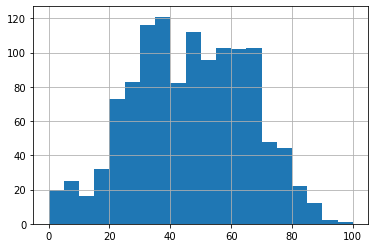

In [55]:
df_hiphop = dataset_v2[dataset_v2['Rap/Hip-Hop'] == 1]
df_hiphop['Popularity'].hist(bins=20)

The "Rap Caviar" playlist on Spotify is a curated collection of very popular rap music. Pulling tracks from that playlist should make things more even on the high end. First get track URI's from playlist.

In [56]:
playlist_uri = 'spotify:playlist:37i9dQZF1DX0XUsuxWHRQd'
playlist_tracks = sp.playlist_tracks(playlist_uri)['items']
playlist_track_uris = [track['track']['uri'] for track in playlist_tracks]

Get track audio features from track URIs.

In [57]:
rap_caviar_audio_features = sp.audio_features(tracks=playlist_track_uris)
rap_caviar_audio_features[0]

{'danceability': 0.904,
 'energy': 0.723,
 'key': 11,
 'loudness': -5.224,
 'mode': 0,
 'speechiness': 0.26,
 'acousticness': 0.0631,
 'instrumentalness': 0,
 'liveness': 0.185,
 'valence': 0.835,
 'tempo': 145.013,
 'type': 'audio_features',
 'id': '2MbdDtCv5LUVjYy9RuGTgC',
 'uri': 'spotify:track:2MbdDtCv5LUVjYy9RuGTgC',
 'track_href': 'https://api.spotify.com/v1/tracks/2MbdDtCv5LUVjYy9RuGTgC',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/2MbdDtCv5LUVjYy9RuGTgC',
 'duration_ms': 227478,
 'time_signature': 4}

Format audio features into dataframe.

In [58]:
df_rap_caviar_audio_features = pd.DataFrame([{
    'Track URI': track['uri'],
    'Duration (ms)': track['duration_ms'],
    'Tempo': track['tempo'],
    'Key': track['key'],
    'Mode': track['mode'],
    'Time Signature': track['time_signature'],
    'Danceability': track['danceability'],
    'Energy': track['energy'],
    'Loudness': track['loudness'],
    'Speechiness': track['speechiness'],
    'Acousticness': track['acousticness'],
    'Instrumentalness': track['instrumentalness'],
    'Liveness': track['liveness'],
    'Valence': track['valence']
} for track in rap_caviar_audio_features])
df_rap_caviar_audio_features.head()

,Acousticness,Danceability,Duration (ms),Energy,Instrumentalness,Key,Liveness,Loudness,Mode,Speechiness,Tempo,Time Signature,Track URI,Valence
0,0.0631,0.904,227478,0.723,0.0,11,0.185,-5.224,0,0.2600,145.013,4,spotify:track:2MbdDtCv5LUVjYy9RuGTgC,0.835
1,0.1140,0.825,197760,0.458,0.0,0,0.102,-7.470,1,0.0577,145.115,4,spotify:track:3nS9a01VvXHQriLqJYwRqG,0.161
2,0.1140,0.823,190476,0.586,0.0,6,0.193,-6.606,0,0.2000,125.971,4,spotify:track:0PvFJmanyNQMseIFrU708S,0.347
3,0.0538,0.752,163902,0.673,0.0,10,0.133,-5.792,0,0.1530,164.009,4,spotify:track:2QqJTIlGKRLJC3onkavYEz,0.350
4,0.1830,0.868,154767,0.550,0.0,6,0.109,-6.417,1,0.2260,117.943,4,spotify:track:3MmCFghNjzZMn3HKqbVizn,0.464


Get track popularity and followers.

In [59]:
df_rap_caviar_track_popularity = get_spotify_track_popularity_and_artist_followers(sp, playlist_track_uris)
df_rap_caviar_track_popularity.head()

,Artist Followers,Popularity,Track URI
0,331266,88,spotify:track:2MbdDtCv5LUVjYy9RuGTgC
1,2213333,85,spotify:track:3nS9a01VvXHQriLqJYwRqG
2,880451,86,spotify:track:0PvFJmanyNQMseIFrU708S
3,1578386,86,spotify:track:2QqJTIlGKRLJC3onkavYEz
4,10549573,81,spotify:track:3MmCFghNjzZMn3HKqbVizn


Merge dataframes and drop Track URI.

In [60]:
print('Before')
print(df_rap_caviar_audio_features.shape)
dataset_v2_addition = df_rap_caviar_audio_features.merge(df_rap_caviar_track_popularity, on='Track URI')
print('After')
print(dataset_v2_addition.shape)

Before
(50, 14)
After
(50, 16)


Drop unecessary columns.

In [61]:
dataset_v2_addition.drop(['Track URI', 'Time Signature', 'Key'], axis=1, inplace=True)

Convert duration to minutes.

In [62]:
dataset_v2_addition['Duration (minutes)'] = round(dataset_v2_addition['Duration (ms)'].div(1000*60), 2)
dataset_v2_addition.drop('Duration (ms)', axis=1, inplace=True)

Add genre dummy features.

In [63]:
dataset_v2_addition['Rap/Hip-Hop'] = len(dataset_v2_addition)*[1]
non_hip_hop_genres = ['Electronic', 'Experimental', 'Folk/Country', 'Global', 'Jazz', 'Metal', 'Pop/R&B', 'Rock']
for genre in non_hip_hop_genres:
    dataset_v2_addition[genre] = len(dataset_v2_addition)*[0]
    
dataset_v2_addition.head()

,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Mode,Speechiness,Tempo,Valence,...,Duration (minutes),Rap/Hip-Hop,Electronic,Experimental,Folk/Country,Global,Jazz,Metal,Pop/R&B,Rock
0,0.0631,0.904,0.723,0.0,0.185,-5.224,0,0.2600,145.013,0.835,...,3.79,1,0,0,0,0,0,0,0,0
1,0.1140,0.825,0.458,0.0,0.102,-7.470,1,0.0577,145.115,0.161,...,3.30,1,0,0,0,0,0,0,0,0
2,0.1140,0.823,0.586,0.0,0.193,-6.606,0,0.2000,125.971,0.347,...,3.17,1,0,0,0,0,0,0,0,0
3,0.0538,0.752,0.673,0.0,0.133,-5.792,0,0.1530,164.009,0.350,...,2.73,1,0,0,0,0,0,0,0,0
4,0.1830,0.868,0.550,0.0,0.109,-6.417,1,0.2260,117.943,0.464,...,2.58,1,0,0,0,0,0,0,0,0


Concatenate data to dataset_v2.

In [64]:
dataset_v2 = pd.read_pickle('../data/dataset_v2.pkl')
dataset_v2B = dataset_v2.append(dataset_v2_addition)
dataset_v2B = dataset_v2B[['Electronic', 'Experimental', 'Folk/Country', 'Global', 'Jazz', 'Metal', 'Pop/R&B', 
                         'Rap/Hip-Hop', 'Rock', 'Duration (minutes)', 'Tempo', 'Mode','Acousticness', 'Danceability', 
                         'Energy', 'Instrumentalness', 'Liveness', 'Loudness', 'Speechiness', 'Valence', 
                         'Artist Followers', 'Popularity']]
dataset_v2B.to_pickle('../data/dataset_v2.pkl')

/opt/anaconda3/envs/pitchforkratings/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


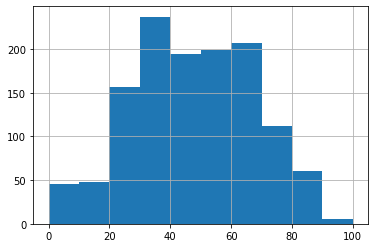

In [65]:
dataset_v2B[dataset_v2B['Rap/Hip-Hop'] == 1]['Popularity'].hist()